<a href="https://colab.research.google.com/github/Yuumiera/CreditScoreClassification/blob/main/CreditScoreClassificaitonML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-learn==1.0.2
!pip install xgboost==1.7.6
!pip install lightgbm==3.3.5
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import seaborn as sns


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 98.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.29.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.0.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 4.5 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.3
    Uninstalling xgboost-2.1.3:
      Successfully uninstalled xgboost-2.1.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.3 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing ins

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Loading the data
train_data = pd.read_csv("/content/drive/MyDrive/train.csv")

In [ ]:
# Data Exploration
print("\n--- Train Dataset Information ---\n")
print(train_data.info()) # Display dataset structure and types
print("\n--- Missing Values in Train Dataset ---\n")
print(train_data.isnull().sum()) # Check for missing values

# Handling Missing Values
train_data = train_data.dropna()


--- Train Dataset Information ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  int64  
 1   Customer_ID               100000 non-null  int64  
 2   Month                     100000 non-null  int64  
 3   Name                      100000 non-null  object 
 4   Age                       100000 non-null  float64
 5   SSN                       100000 non-null  float64
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  float64
 8   Monthly_Inhand_Salary     100000 non-null  float64
 9   Num_Bank_Accounts         100000 non-null  float64
 10  Num_Credit_Card           100000 non-null  float64
 11  Interest_Rate             100000 non-null  float64
 12  Num_of_Loan               100000 non-null  float64
 13  Type_of_L

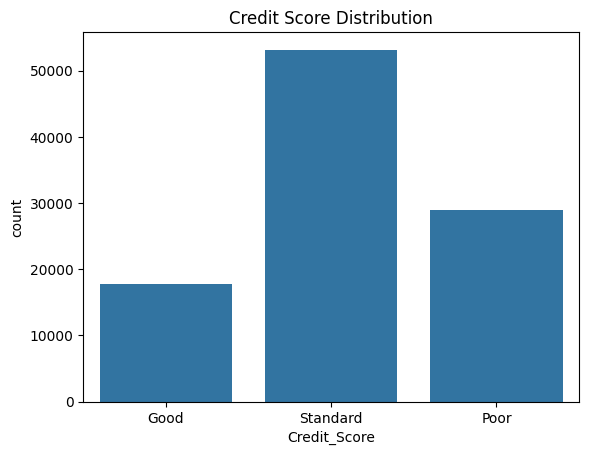

In [ ]:
# Credit Score Distribution
top_labels = train_data['Credit_Score'].value_counts()
sns.countplot(data=train_data, x='Credit_Score')
plt.title("Credit Score Distribution")
plt.show()

In [ ]:
# Encoding the Target Variable
label_encoder = LabelEncoder() # Convert target variable to numeric labels
train_data['Credit_Score'] = label_encoder.fit_transform(train_data['Credit_Score'])

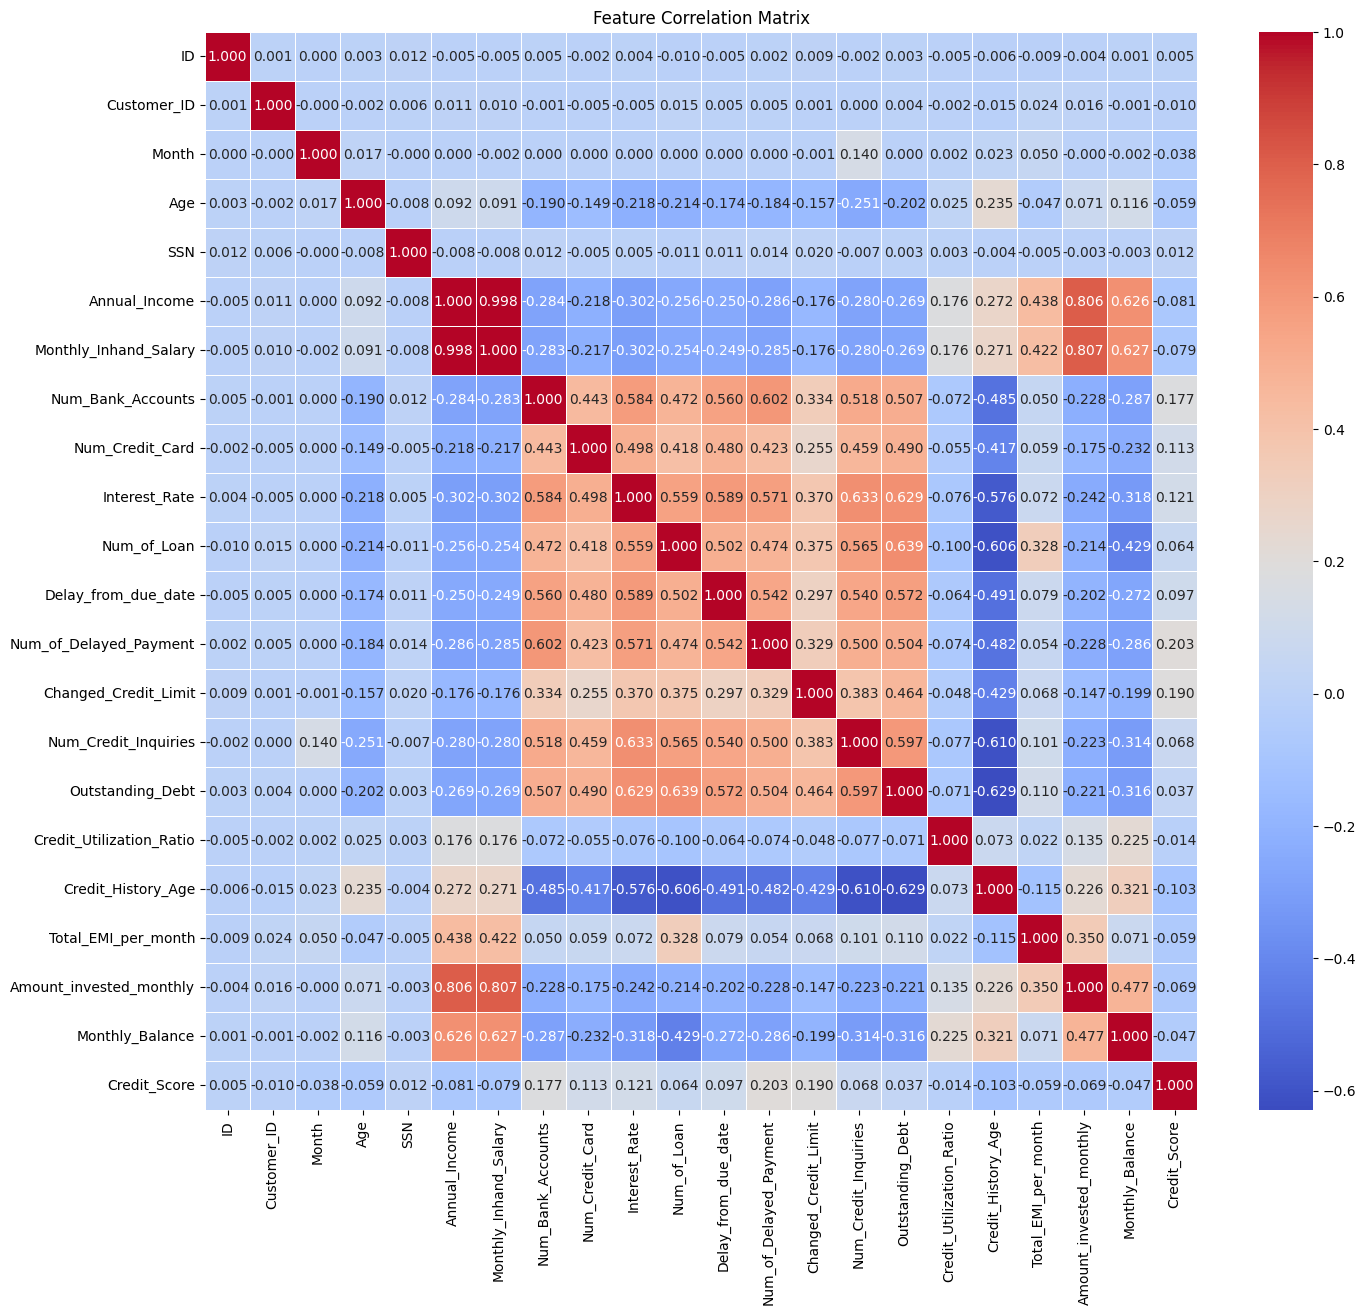

In [ ]:
# Correlation Matrix
numeric_columns = train_data.select_dtypes(include=['number'])
corr = numeric_columns.corr()
plt.figure(figsize=(16, 14))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

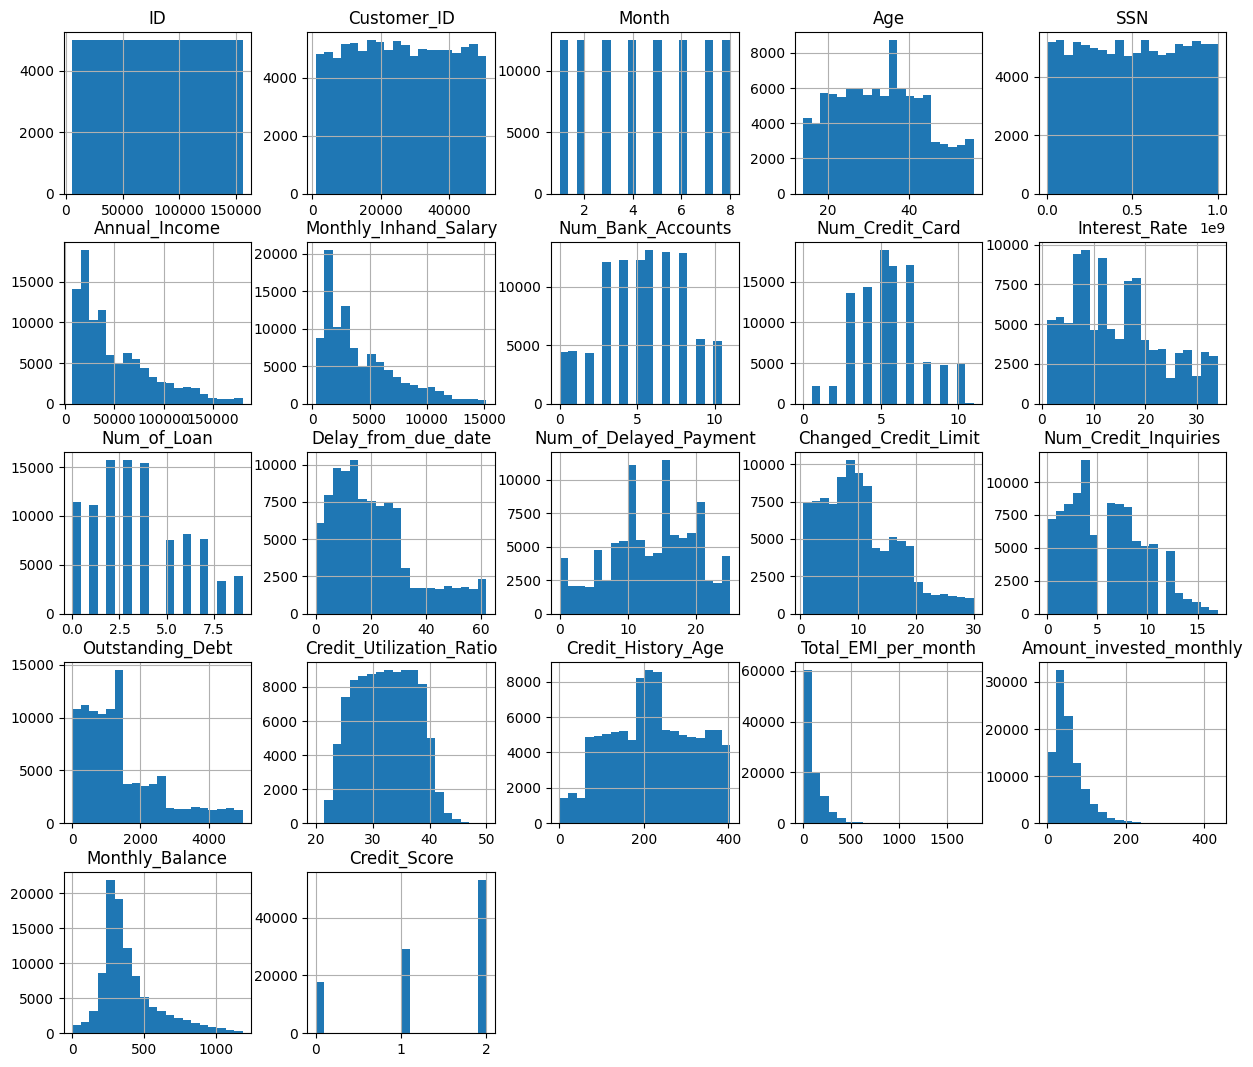

In [ ]:
# Plotting Histograms for Numerical Features
train_data.hist(figsize=(15, 13), bins=20)
plt.show()

In [ ]:
# Selecting Relevant Features
features = [
    'Num_of_Delayed_Payment',
    'Changed_Credit_Limit',
    'Num_Bank_Accounts',
    'Interest_Rate',
    'Num_Credit_Card',
    'Outstanding_Debt',
    'Delay_from_due_date',
    'Credit_History_Age',
    'Monthly_Inhand_Salary'
]

In [ ]:
# Preparing Data for Model Training
X = train_data[features]
y = train_data['Credit_Score']

In [ ]:
# Applying SMOTE for Handling Class Imbalance
smote = SMOTE(random_state=42)  # Oversampling minority classes
X, y = smote.fit_resample(X, y)

In [ ]:
# Splitting Data into Train and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Scaling
scaler = StandardScaler() # Standardize features
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
# Hyperparameter Tuning with RandomizedSearchCV
def get_best_model_and_params():
    models = {
        'RandomForest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [50, 100, 150, 200],
                'max_depth': [5, 10, 20, None],
                'min_samples_split': [2, 5, 10]
            }
        },
        'AdaBoost': {
            'model': AdaBoostClassifier(random_state=42),
            'params': {
                'n_estimators': [50, 100, 150, 200],
                'learning_rate': [0.01, 0.1, 1.0]
            }
        },
        'XGBoost': {
            'model': XGBClassifier(random_state=42),
            'params': {
                'n_estimators': [50, 100, 150, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 10]
            }
        },
        'LightGBM': {
            'model': LGBMClassifier(random_state=42),
            'params': {
                'n_estimators': [50, 100, 150, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [-1, 5, 10]
            }
        }
    }

    best_model = None
    best_params = None
    best_score = 0

    for model_name, mp in models.items():
        print(f"Training {model_name}...")
        rs = RandomizedSearchCV(mp['model'], mp['params'], n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
        rs.fit(X_train, y_train)
        if rs.best_score_ > best_score:   # Update best model if current one performs better
            best_model = rs.best_estimator_
            best_params = rs.best_params_
            best_score = rs.best_score_
        print(f"{model_name} Best Score: {rs.best_score_:.4f}")

    return best_model, best_params, best_score

In [ ]:
best_model, best_params, best_score = get_best_model_and_params()
print(f"\nBest Model: {best_model} with Score: {best_score:.4f}")

# Evaluating the Best Model
y_pred = best_model.predict(X_val)
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred))  # Performance metrics

Training RandomForest...
RandomForest Best Score: 0.8672
Training AdaBoost...
AdaBoost Best Score: 0.6886
Training XGBoost...
XGBoost Best Score: 0.8687
Training LightGBM...
LightGBM Best Score: 0.8300

Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...) with Score: 0.8687

Classif

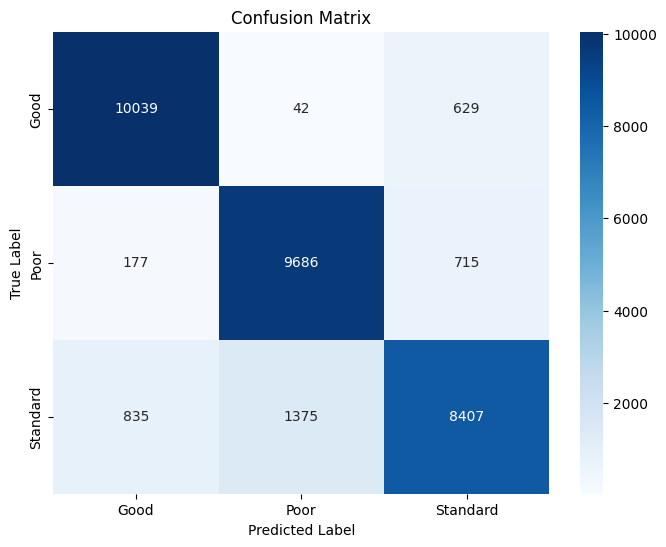

In [ ]:
# Visualizing Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

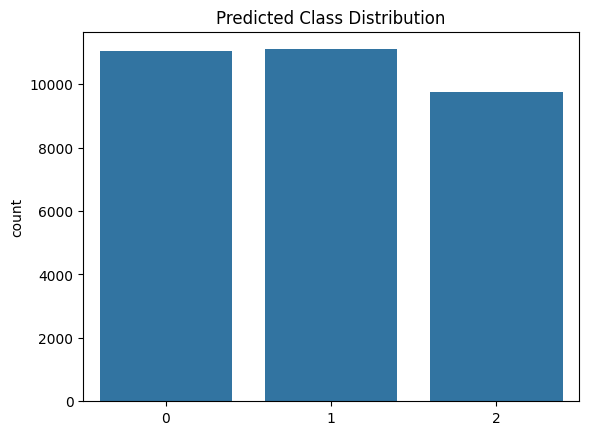

In [ ]:
# Class Distribution
sns.countplot(x=y_pred)
plt.title("Predicted Class Distribution")
plt.show()

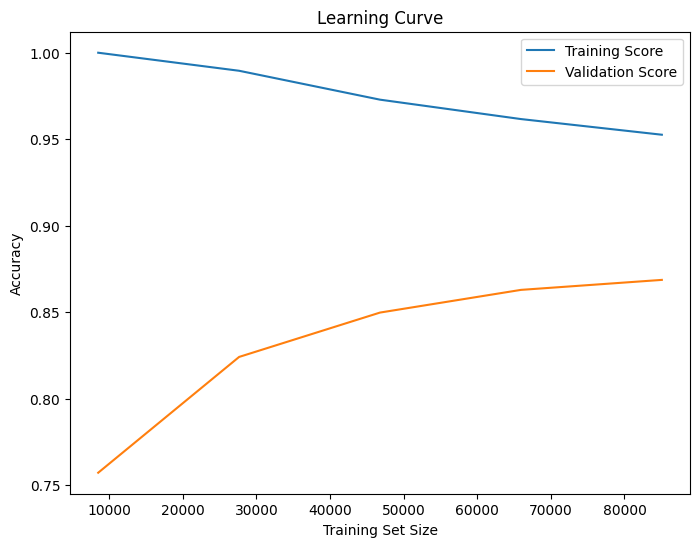

In [ ]:
# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, val_mean, label="Validation Score")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

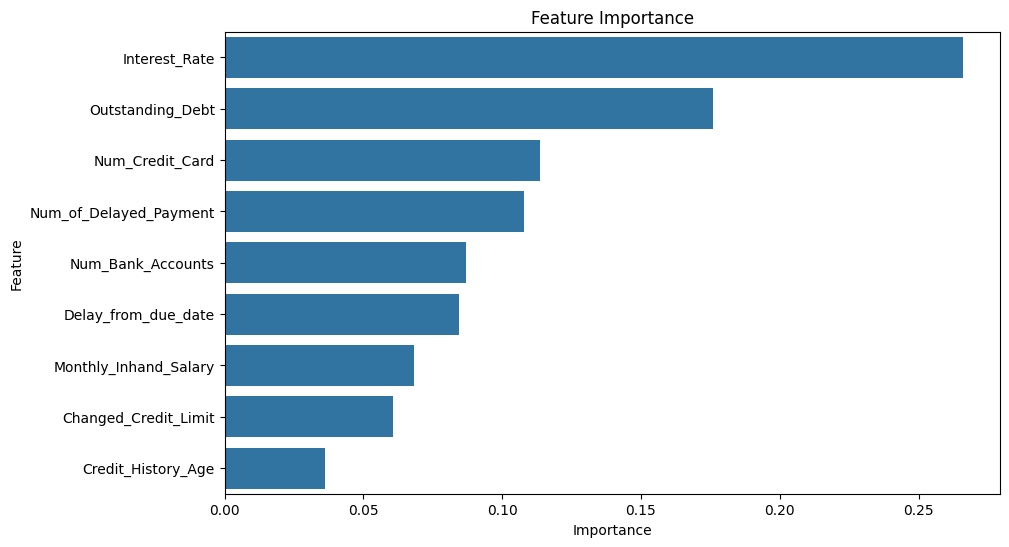

In [ ]:
# Feature Importance
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_names = features
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title("Feature Importance")
    plt.show()